### Program written by Pablo Sánchez-Palencia, 2022
Built-up on the basis of the code previously written by Scott Midgley

Scope: To train and test GBDT model for band gap and mixing energy screening in the configurational space of Sn2GeN4 spinel solid solutions.  

In [1]:
### USER INPUT REQUIRED ###

# Windows path
repodir = r'C:\Users\pablo\OneDrive\Documentos\GitHub\GeSn2N4-ML'

# Define percentage of training data to use for training. 
split = 20
#split = 50
#split = 80

# Define the structural descriptor to use for training the model
#descriptor="Coulomb_mm"
#descriptor="Coulomb_ds"
#descriptor="Coulomb_corr"
#descriptor="Sine_mm"
#descriptor="Sine_ds"
#descriptor="Ewald_mm"
#descriptor="Ewald_ds"
#descriptor="MBTR"
descriptor="CorrM"

#Define property to predict with the model
#feature="SCF"
feature="MixE";labelsname="Mixing Energy"
#feature="BGE";labelsname="Bandgap"
#feature="HSE-corr";labelsname="Bandgap"

In [2]:
# Import modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
import sklearn
import time
import pickle
import shap

In [3]:
# Define GBDT hyperparameters. 
params = {'n_estimators': 1000,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
model = GradientBoostingRegressor(**params)

In [4]:
#Define generic functions to run ensembles
def train_predict_model(model):
    start=time.time()
    model.fit(Xtrain, ytrain)
    end=time.time()
    print(f"Runtime of the program is {(end - start)/60} min")
    predictions = model.predict(Xtest)
    return predictions 

def score_model(realval,preds,graph=False,print_results=False):
    mae = mean_absolute_error(realval,preds)
    maxerr= max(abs(preds.reshape(len(preds),)-realval))
    r2=r2_score(realval,preds)
    if print_results==True:
        print('Mean absolute error {} ev'.format(mae))
        print('Maximum error {} ev'.format(maxerr))
        print('R2 = {}'.format(r2))
    if graph==True:
        plt.figure()
        plt.plot(realval.reshape(len(preds),),preds,'o')
        eje=np.linspace(min(preds),max(preds),10)
        plt.plot(eje,eje)
        plt.ylabel("Predicted values")
        plt.xlabel("Calculated values")
        plt.show()
        plt.close()
    return mae,maxerr,r2

## Load the data

In [5]:
# Import data and shuffle (optional).
ener = pd.read_pickle(repodir + '\\descriptors\\input_data_cm.pkl')
sm_data = pd.read_pickle(repodir + '\\descriptors\\input_data_sm.pkl')
em_data = pd.read_pickle(repodir + '\\descriptors\\input_data_em.pkl')
mbtr_data = pd.read_pickle(repodir + '\\descriptors\\input_data_mbtr.pkl')

ener["Sine_ds"]=sm_data["Sine_ds"]
ener["Sine_mm"]=sm_data["Sine_mm"]
ener["Ewald_ds"]=em_data["Ewald_ds"]
ener["Ewald_mm"]=em_data["Ewald_mm"]
ener["MBTR"]=mbtr_data["MBTR"]

ener = ener.sample(frac=1,random_state=91)

In [6]:
# Split data frame into training, validation, and testing data. 
l=len(ener)

e_test = ener.iloc[:l//10+1] #10% of data for testing model
e_val = ener.iloc[l//10+1:l//10*2+1] #10% of data for validation

if split == int(20):
    e_train = ener.iloc[l//10*2+1:l//10*4+1] #30% of data for training
elif split == int(50):
    e_train = ener.iloc[l//10*2+1:l//10*7+1] #50% of data for training
elif split == int(80):
    e_train = ener.iloc[l//10*2+1:l] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')

In [7]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train[descriptor].to_numpy()
Xtrain = np.stack(Xtrain)
Xval   = e_val[descriptor].to_numpy()
Xval   = np.stack(Xval)
Xtest  = e_test[descriptor].to_numpy()
Xtest  = np.stack(Xtest)
ytrain = e_train[feature].to_numpy()
yval   = e_val[feature].to_numpy()
ytest  = e_test[feature].to_numpy()
itrain = e_train['tag'].to_numpy()
ival   = e_val['tag'].to_numpy()
itest  = e_test['tag'].to_numpy()

Number of training data points =  202


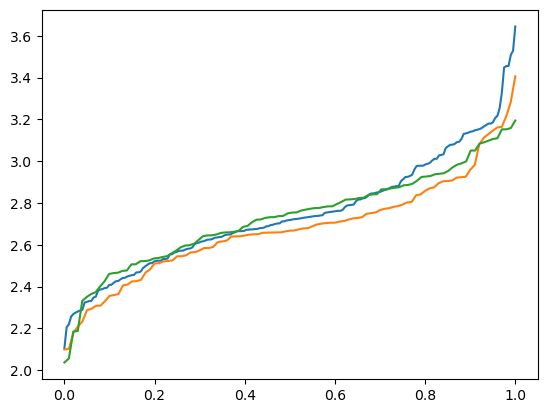

In [8]:
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

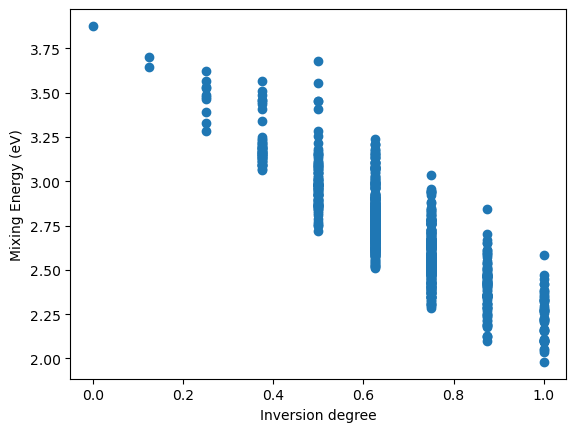

In [9]:
plt.figure()
plt.plot(ener['inv'],ener[feature],'o')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

## Train a model from scrach 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.0244693398475647 min
Mean absolute error 0.02792895836558507 ev
Maximum error 0.14106621859069968 ev
R2 = 0.9731781387348191


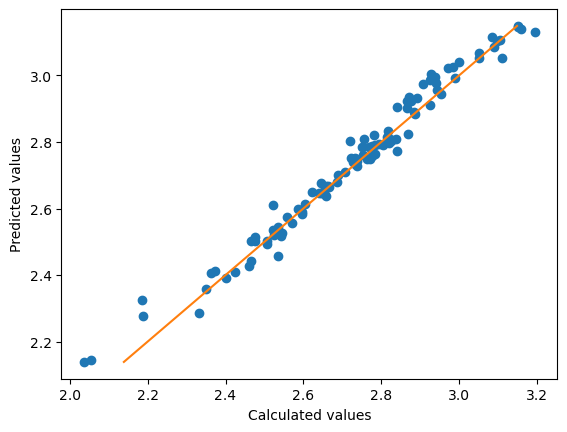

In [10]:
# Train GBDT 
ypred = train_predict_model(model)
mae,maxerr,r2=score_model(ytest,ypred,graph=True,print_results=True)

Mean absolute error 0.003259286785935826 ev
Maximum error 0.013080332515278847 ev
R2 = 0.9997942234794501


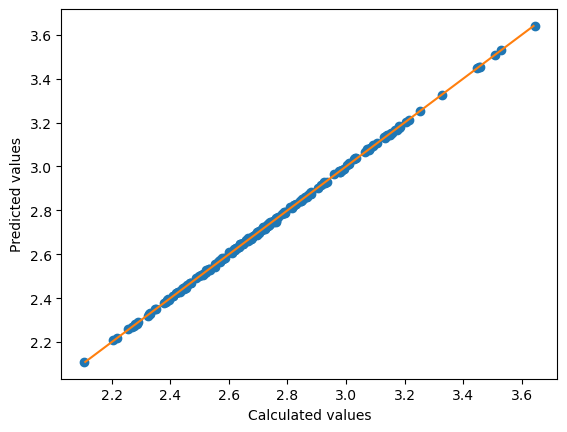

(0.003259286785935826, 0.013080332515278847, 0.9997942234794501)

In [11]:
trainpred=model.predict(Xtrain)
score_model(ytrain,trainpred,graph=True,print_results=True)

Mean absolute error 0.020634309656245183 ev
Maximum error 0.20688159744340195 ev
R2 = 0.9804981445327288


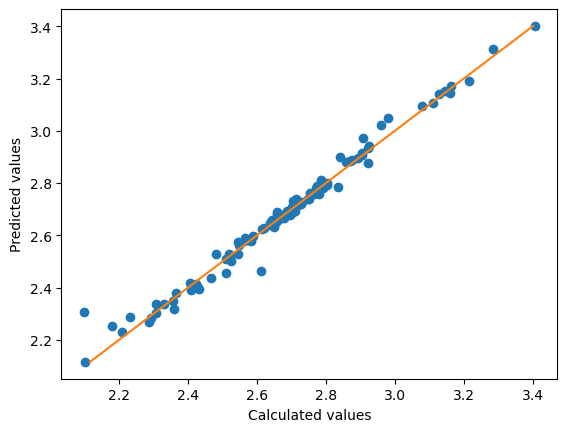

(0.020634309656245183, 0.20688159744340195, 0.9804981445327288)

In [12]:
valpred=model.predict(Xval)
score_model(yval,valpred,graph=True,print_results=True)

## Running the model recursively in ensembles 

You can train the model in ensembles of variable size and get averages of metrics and predictions.

In [13]:
n=10
preds_ens = np.zeros(shape=(n, len(Xtest)))
for i in range(n):
    model = GradientBoostingRegressor(**params)
    sklearn.utils.shuffle(Xtrain, ytrain)
    preds_ens[i,:] = train_predict_model(model)
mean_preds = np.mean(preds_ens, axis=0)
mean_std = np.std(preds_ens, axis=0)

The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.023853000005086264 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.023719815413157146 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.024735796451568603 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.024602595965067545 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.016473877429962158 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.015757652123769124 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.01740670601526896 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.017073587576548258 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.015524423122406006 min


The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.


Runtime of the program is 0.014025664329528809 min


Mean absolute error 0.027868386789959575 ev
Maximum error 0.14099591617422025 ev
R2 = 0.9732883595791676


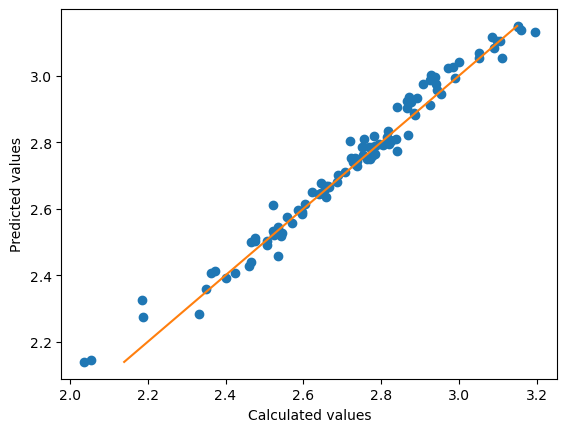

In [14]:
mae_means,maxerr_means,r2_means=score_model(ytest,mean_preds,graph=True,print_results=True)

In [15]:
all_mae=[];all_maxerr=[];all_r2=[];
for i in range(n):
    mae,maxerr,r2=score_model(ytest,preds_ens[i,:])
    all_mae.append(mae)
    all_maxerr.append(maxerr)
    all_r2.append(r2)
print(np.mean(all_mae))
print(np.mean(all_maxerr))
print(np.mean(all_r2))

0.027880672051428062
0.14099591617422041
0.973262212941297


## SHAP analysis 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

In [16]:
explainer = shap.Explainer(model, Xtrain)
shap_values = explainer(Xtest)

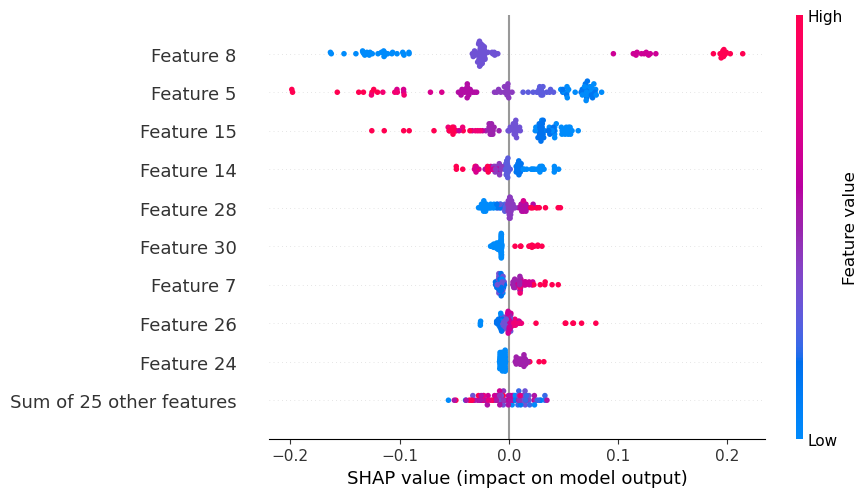

In [17]:
shap.plots.beeswarm(shap_values)